In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.linear_model as lm 
import sklearn.ensemble as em 
from sklearn.svm import SVC

In [3]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 50)
np.set_printoptions(suppress=True)
rseed = 1234

In [4]:
# download data 
# if you don't have these csvs, run the preprocessing notebook. 
# Ill turn this this into a py file later, but for now should be fine 
dfs = pd.read_csv("all_processed_df.csv")

/Users/benji/anaconda3/envs/play/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# add outcome var + unique id 
dfs['outcome'] = np.where(dfs['state']=="successful", 1, 0)
dfs['un_id'] = np.arange(0, dfs.shape[0], 1)
dfs['name_len'] = dfs['name'].str.len()

In [6]:
def lnom(df, grp_col, target_col="outcome", min_n=1000):
    """
    Encode our categorical variables, by calculating the leave-nothing-out mean, 
    i.e. for each category, we calculate the mean of the target and use it as our feature 
    """
    out_col = grp_col + "_" + target_col + "_mean"
    tmp_df = df.groupby([grp_col])[target_col].agg(
        [(out_col, "mean"), ("c", "count")]
    )
    tmp_df = tmp_df.loc[tmp_df["c"] >= min_n].reset_index()
    return tmp_df[[grp_col, out_col]]

def add_lnoms(df1, df2, target_col="outcome"):
    """
    lnom = "Leave none out mean", i.e. calculate the average within a group. (as opposed to a loom -- "leave one out of mean")
    Add lnoms for a bunch of categorical variables (currently hard-coded). 
    Lnoms are calculated using df2 and then merged onto df1 (i.e. insuring indepdence, though don't think this all that important). 
    Target column is specified with target_col. 
    """
    dfs_lnom = df1.merge(
        lnom(df2, "currency", target_col), on="currency", how="left"
    ).merge(
        lnom(df2, "country", target_col), on="country", how="left"
    ).merge(
        lnom(df2, "cat_id", target_col), on="cat_id", how="left"
    ).merge(
        lnom(df2, "cat_parent_id", target_col), on="cat_parent_id", how="left"
    ).merge(
        lnom(df2, "loc_type", target_col), on="loc_type", how="left"
    ).merge(
        lnom(df2, "loc_id", target_col), on="loc_id", how="left"
    )
    return dfs_lnom

def replace_nas(df1, df2, df1_varlist):
    """
    Impute NAs in our data (df1) with the overall means (best-guess) from a independent dataframe (df2). 
    """
    # if grouped outcome means are missing, replace w/ over all outcome mean 
    df1.loc[:, df1.columns.str.contains('outcome')]  = df1.loc[:, df1.columns.str.contains('outcome')].fillna(  df2['outcome'].mean()  )
    
    # if using usd_goal variables 
    #df1.loc[:, df1.columns.str.contains('usd_goal')] = df1.loc[:, df1.columns.str.contains('usd_goal')].fillna( df2['usd_goal'].mean() )
    
    # if blurb len is missing, either: blurb is missing because it doesn't exist or it couldn't be scraped 
    # to be more conservative Im just assuming the later and setting equal to blurb mean 
    df1['blurb_len'] = df1['blurb_len'].fillna( df2['blurb_len'].mean() )
    return df1 

In [7]:
#X_train, X_test, y_train, y_test = train_test_split(dfs, dfs["outcome"], test_size=0.3, random_state=rseed)
# to avoid info leakage, we'll calculate the averages on a different df 
#          I don't think it would be a problem to calculate on train df, but currently trying to remove 
#          any even potential problems to figure out performance ... 
X_train, X_lnom, y_train, y_lnom = train_test_split(dfs, dfs["outcome"], test_size=0.3, random_state=rseed)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=rseed)
# add outcome lnoms  
X_train_lnom = add_lnoms(X_train, X_lnom, "outcome")
X_test_lnom = add_lnoms(X_test, X_lnom, "outcome")
# add usd_goal lnoms (let's ignore these for now --> don't help performance at all, if anything hurt it )
#X_train_lnom = add_lnoms(X_train_lnom, X_lnom, "usd_goal")
#X_test_lnom = add_lnoms(X_test_lnom, X_lnom, "usd_goal")

In [8]:
# specify feature set here

# categorical variables (we won't use these raw, but will use lnom results)
categorical_cols = ["currency", "country", "cat_id", "cat_parent_id", "loc_id", "loc_type"]
# for results for lnom 
X_lnom_cols_outcome = pd.Series(categorical_cols) + "_outcome_mean"
X_lnom_cols_usdgoal = pd.Series(categorical_cols) + "_usd_goal_mean"
# specify other features here 
X_cols = ["blurb_len", "name_len", "usd_goal"]
# join all features together 
X_cols_all = np.concatenate((X_cols, X_lnom_cols_outcome))
#X_cols_all = np.concatenate((X_cols, X_lnom_cols_outcome, X_lnom_cols_usdgoal))
# subset features on our train and test data 
X_train_lnom = X_train_lnom[X_cols_all]
X_test_lnom = X_test_lnom[X_cols_all]
# make sure all values are floats, if na --> fill w/ 0.5 (i.e. we have no better guess)
# there aren't many nas though, only really in cat_parent_id and loc_type 
X_test_lnom = replace_nas(X_test_lnom, X_lnom, X_cols_all)
X_train_lnom = replace_nas(X_train_lnom, X_lnom, X_cols_all)

In [30]:
#### ---> IGNORE THIS CELL FOR NOW <--- ####
### only use when using usd_goal vars, which we aren't 
## subtract actual usd_goal from category goal 
X_train_lnom[X_lnom_cols_usdgoal] = np.log(X_train_lnom[X_lnom_cols_usdgoal]+1).sub(np.log(X_train_lnom['usd_goal']+1), axis= 0 )
X_test_lnom[X_lnom_cols_usdgoal] =  np.log(X_test_lnom[X_lnom_cols_usdgoal]+1).sub(np.log(X_test_lnom['usd_goal']+1), axis= 0 )

KeyError: "None of [Index(['currency_usd_goal_mean', 'country_usd_goal_mean',\n       'cat_id_usd_goal_mean', 'cat_parent_id_usd_goal_mean',\n       'loc_id_usd_goal_mean', 'loc_type_usd_goal_mean'],\n      dtype='object')] are in the [columns]"

In [9]:
# specify some model performance funcs 
def rmse(y, yhat):
    print("RMSE:", np.round(np.sqrt( np.mean( (y - yhat)**2 ) ), 3))
    
def acc(y, yhat):
    yhat_rounded = np.round(yhat)
    print("Accuracy:", np.round(np.mean(yhat_rounded == y), 3))
    
def tfpn(y, yhat):
    tp = np.logical_and((y==1), (yhat==1)).sum()
    fp = np.logical_and((y==0), (yhat==1)).sum()
    fn = np.logical_and((y==1), (yhat==0)).sum()
    tn = np.logical_and((y==0), (yhat==0)).sum()
    
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    res = {
        'False Positive Rate':np.round(fpr,3), 
        'False Negative Rate':np.round(fnr,3), 
        'True Positive Rate':np.round(tpr,3), 
        'True Negative Rate':np.round(tnr,3)
    }
    [print(k, ":", v) for k, v in res.items()]

### Models

In [10]:
## 1. Naive approach:
# Idea: what if we just guess the outcome of previous projects within this category
naive = np.array(np.round(X_test_lnom['cat_id_outcome_mean']).reset_index(drop=True))
rmse(y_test, naive)
acc(y_test, naive)

RMSE: 0.581
Accuracy: 0.662


In [11]:
## 1.5 OLS: 
ols = lm.LinearRegression(normalize=False)
ols.fit(X_train_lnom, y_train)
y_test_hat = ols.predict(X_test_lnom)
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

RMSE: 0.417
Accuracy: 0.72


In [12]:
## 2. Lasso
# Since our feature space isn't that large and also not very rich (at least in a linear sense), don't expect great results here  
clf_lasso = lm.Lasso(alpha=0.05, normalize=False, random_state=rseed)
clf_lasso.fit(X_train_lnom, y_train)
y_test_hat = clf_lasso.predict(X_test_lnom)
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

RMSE: 0.474
Accuracy: 0.633


In [13]:
## 3. Ridge
# Similar expectations to lasso, though at least it won't kick out features from our model, so should do a bit better  

# training procedure for a cross-validated ridge, but don't think this is necessary right now 
#clf_ridgecv = lm.RidgeCV(alphas=np.arange(0.1, 1, 0.02), cv=10).fit(X_train_lnom, y_train)
#print(clf_ridgecv.alpha_)
#y_test_hat = clf_ridgecv.predict(X_test_lnom)
#rmse(y_test, y_test_hat)
#acc(y_test, y_test_hat)
# train ridge 
clf_ridge = lm.Ridge(alpha=0.055, normalize=False, random_state=rseed)
clf_ridge.fit(X_train_lnom, y_train)
y_test_hat = clf_ridge.predict(X_test_lnom)
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

RMSE: 0.417
Accuracy: 0.72


In [14]:
## 4. Logistic Reg  
# Similar expectations to lasso + ridge 
# To avoid regularization set C to be very large and/or penalty to none 
glf = lm.LogisticRegression(C=10000, random_state=rseed, penalty='l2')
glf.fit(X_train_lnom, y_train)
print("Coefficients:", glf.intercept_, np.round(glf.coef_, 3)) 
y_test_hat = glf.predict(X_test_lnom)
print(pd.Series(y_test_hat).value_counts())
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

Coefficients: [0.00026786] [[-0.001  0.021 -0.     0.     0.     0.001  0.     0.     0.   ]]
1    61517
0    12481
dtype: int64
RMSE: 0.594
Accuracy: 0.648


In [20]:
#### ---> DON'T RUN THIS <--- ####
# this seems very slow and honestly don't have great results
# definitely should look into improving SVM as it has potential, but...

## 5. SVM 
svm = SVC(C=0.1, random_state=rseed, kernel='sigmoid', verbose=True)
svm.fit(X_train_lnom, y_train)
y_test_hat = svm.predict(X_test_lnom)
print(pd.Series(y_test_hat).value_counts())
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

[LibSVM]1    27021
0     9468
dtype: int64
RMSE: 0.593
Accuracy: 0.648


In [71]:
##### ---> NOTE: this will take a while to execute 

## 6. Random Forest 
# set up a parameter grid to find optimal parameters
param_grid = {
    'n_estimators': [5, 10, 20], 
    'max_depth': [5, 10, 15, 25, 35], 
    'max_features': ['auto', 'sqrt'], 
    'min_samples_split':[2, 3, 5, 10], 
    'min_samples_leaf':[1, 2, 3, 10], 
    'bootstrap': [True, False]
    
}
param_grid = {
    'n_estimators': [10, 20], 
    'max_depth': [15, 25, 35], 
    'max_features': ['auto', 'sqrt'], 
    'min_samples_split':[2, 3, 5], 
    'min_samples_leaf':[1, 2, 3], 
    'bootstrap': [False]
    
}
# run grid search over parameters using 5 fold CV verbose on 
grid_rf = GridSearchCV(em.RandomForestClassifier(random_state=rseed, class_weight='balanced'), param_grid, cv=5, verbose=2)
grid_rf.fit(X_train_lnom, y_train)
print(grid_rf.best_params_)
y_test_hat = grid_rf.predict(X_test_lnom)
print(pd.Series(y_test_hat).value_counts())
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)
# OLD: best params = {'bootstrap': False, 'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.6s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.0s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.8s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.8s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.8s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   1.4s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; tota

In [15]:
## 6. Random Forest (cont. )
# selected optimal params from cell above
best_params = {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20, 'max_features': 'auto', 'bootstrap':False}
# run RF 
rf = em.RandomForestClassifier(random_state=rseed, class_weight='balanced', **best_params)
rf.fit(X_train_lnom, y_train)
y_test_hat = rf.predict(X_test_lnom)
y_test_hat_proba = rf.predict_proba(X_test_lnom)
print(pd.Series(y_test_hat).value_counts())
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

0    37781
1    36217
dtype: int64
RMSE: 0.419
Accuracy: 0.824


In [16]:
tfpn(y_test, y_test_hat)
print("F1 score", np.round(metrics.f1_score(y_test, y_test_hat), 3))

False Positive Rate : 0.094
False Negative Rate : 0.233
True Positive Rate : 0.767
True Negative Rate : 0.906
F1 score 0.837


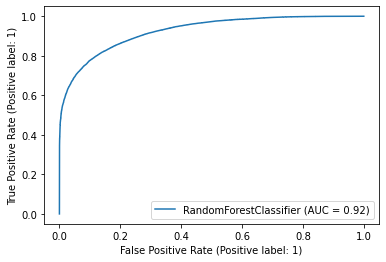

In [17]:
metrics.plot_roc_curve(rf, X_test_lnom, y_test)

#### Generate some plots from RF output

Text(0.5, 0, 'Predicted Probabilities')

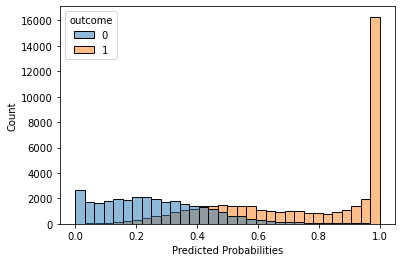

In [18]:
sns.histplot(x=y_test_hat_proba[:, 1], hue=y_test)
plt.xlabel("Predicted Probabilities")

<AxesSubplot:ylabel='Density'>

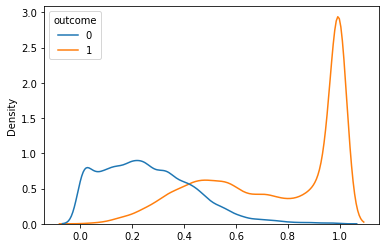

In [19]:
sns.kdeplot(x=y_test_hat_proba[:, 1], hue=y_test)

<AxesSubplot:xlabel='predicted', ylabel='observed'>

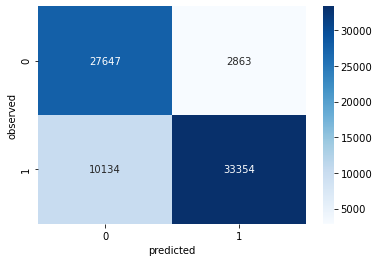

In [20]:
rf_preds = pd.DataFrame({'observed':y_test, 'predicted':y_test_hat})
sns.heatmap(pd.crosstab(rf_preds['observed'], rf_preds['predicted']), annot=True, cmap='Blues', fmt='g')

In [21]:
rf_impt_std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

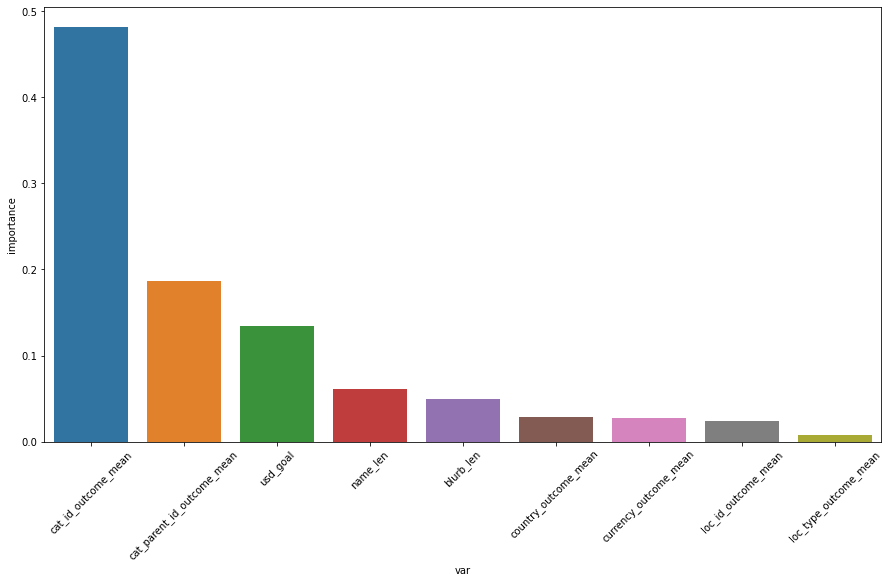

In [22]:
rf_impt = pd.DataFrame({'var':X_cols_all, 'importance':rf.feature_importances_}).sort_values('importance', ascending=False)
plt.subplots(1, 1, figsize=(15, 8))
sns.barplot(x="var", y="importance", data=rf_impt, ci="sd")
plt.xticks(rotation=45)
plt.show()

In [ ]:
#### misc stuff re: dummy encodings: 

def add_dummies(df, dummy_cols):
    return pd.get_dummies(df, drop_first=False, dummy_na=True, columns=dummy_cols)


# specify columns
y_col = "outcome"
# y_col = ["usd_goal"]
X_cols = ["blurb_len", "spotlight", "staff_pick", "cat_position",]
X_dummy_cols = np.concatenate((
    dfs_full.columns[dfs_full.columns.str.startswith("currency")],
    dfs_full.columns[dfs_full.columns.str.startswith("country")], 
    dfs_full.columns[dfs_full.columns.str.startswith("cat_id")], 
    dfs_full.columns[dfs_full.columns.str.startswith("cat_parent_id")], 
    #dfs_full.columns[dfs_full.columns.str.startswith("loc_id")], 
    dfs_full.columns[dfs_full.columns.str.startswith("loc_type")], 
))
X_lnom_cols = pd.Series(dummy_cols) + "_mean"
#X_cols_all = np.concatenate((X_cols, X_dummy_cols))
X_cols_all = np.concatenate((X_cols, X_lnom_cols))


#X = dfs_full[X_cols_all].astype(float)
#y = np.array(dfs_full[y_col])
X = dfs_lnom[X_cols_all].astype(float)
y = np.array(dfs_lnom[y_col])